## Exercise 1 - Preliminary Functions

Objectives:

*   Coding a simple neural network for classification using PyTorch
*   Using a custom Dataset
*   Using DataLoader
*   Difference between full gradient descent and mini-batch gradient descent

In [1]:
# Numpy
import numpy as np

# Matplotlib
import matplotlib.pyplot as plt

# Scikit learn
import sklearn
from sklearn import cluster
from sklearn import datasets as sk_datasets
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

# tqdm for progress bar
from tqdm import trange

In [2]:
# Random seed for reproducability
random_seed = 123
np.random.seed(random_seed)

In [3]:
# Function for splitting into train and test sets
def split(dataset):

    # Get data and labels
    X,Y = dataset

    # Reshape Y to [num_points, 1]
    Y = np.expand_dims(Y, axis=1)

    # Split the data into train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

    print('X_train: {}, X_test: {}, Y_train: {}, Y_test: {}'.format(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape))
    return X_train, X_test, Y_train, Y_test

In [5]:
class CustomDataset(Dataset):

    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        # Select sample
        X = self.X[index]

        # Load data and get label
        x = self.X[index]
        y = self.Y[index]

        return x, y

In [12]:
# Function to check the accuracy of the model on the test set
def check_accuracy(net, test_dataloader):

    # Set the network to eval mode and don't perform gradient updates
    net.eval()
    net.freeze()

    test_accuracies = list()
    for batch_idx, (data, target) in enumerate(test_dataloader):
        predictions = net(data)
        binary_predictions = (predictions>0.5).float()
        correct = (binary_predictions == target).float().mean()
        test_accuracies.append(correct.detach().numpy())
    return np.mean(test_accuracies)

In [15]:
# Plots the decision boundary predicted by the neural network
def plot_decision_boundary_nn(net, X, Y_true, cmap='Paired_r'):

    net.eval()
    net.freeze()
    
    # Predictions for the input X values
    Y = net(X)
    Y = (Y>0.5).float().detach().numpy()

    # For constructing the grid limits
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Make predictions for each value inside the grid and reshape
    Z = net(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()).detach().numpy()
    Z = (Z>0.5)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10,6))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.45)
    plt.contour(xx, yy, Z, colors='k', alpha=1.0)
    plt.scatter(X[:,0], X[:,1], c=Y_true[:,0], cmap=cmap, edgecolors='k');

# Start of Exercise 1

In [107]:
# Define a neural network in Pytorch

class FeedForwardNetwork(nn.Module):
    
    def __init__(self, layer_sizes, dropout_prob=0.0):
        super().__init__()

        self.layer_sizes = layer_sizes
        self.dropout_prob = dropout_prob

        # List to store the layers of this network
        self.layers = nn.ModuleList()

        # Compose the layers
        # The dimension of the weight matrices are calculated from pairs
        # of consecutive entries in the layer_sizes list
        for i, _ in enumerate(self.layer_sizes):
            if i == len(self.layer_sizes) - 1:
                break
            self.layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i+1]))
        
    def forward(self, x):

        # Reshape the input, keeping the batch dimension the same
        x = x.view(-1, self.layer_sizes[0])

        # Apply relu for all hidden layer outputs
        for i in range(0, len(self.layers)-1):
            x = F.relu(self.layers[i](x))

        # Apply softmax to the output of the last layer
        x = torch.sigmoid(self.layers[-1](x))

        return x

    def freeze(self):
        for param in self.parameters():
            param.requires_grad = False
    
    def unfreeze(self):
        for param in self.parameters():
            param.requires_grad = True

    def save(self, net_name='', savedir='models', timestamp=None):

        if timestamp is None:
            timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")

        state_dict = self.state_dict()

        state_file = '{}/state_{}_{}.pt'.format(savedir, net_name, timestamp)

        # Save the model state
        torch.save(state_dict, state_file)

        print('Network parameters saved in {}'.format(state_file))

    @staticmethod
    def load(net_name='', timestamp='', savedir='models', **constructor_params):
        
        state_file = '{}/state_{}_{}.pt'.format(savedir, net_name, timestamp)
        
        # Create a network object with the constructor parameters
        net = FeedForwardNetwork(**constructor_params)

        # Load the weights
        net.load_state_dict(torch.load(state_file))
        net.eval()

        return net

X_train: (7500, 2), X_test: (2500, 2), Y_train: (7500, 1), Y_test: (2500, 1)
(7500, 2) (7500, 1)


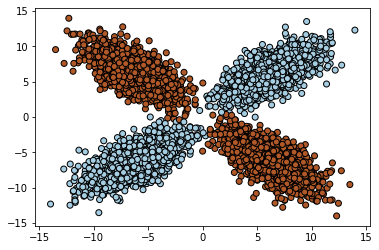

In [22]:
def get_petal_dataset(num_points):

    assert num_points%4==0, 'num_points should be divisible by 4'

    cov = np.array([[2.0, 1.3], [1.3, 2.0]])*2.0
    mean = np.array([5.0,5.0])

    theta = np.pi/2
    rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

    X1 = np.random.multivariate_normal(mean, cov, num_points//4) + np.array([0.7, 0.7]) + np.random.rand(num_points//4,2)*1.0
    Y1 = np.ones((X1.shape[0],))

    X2 = np.dot(rot_matrix, X1.T).T
    Y2 = np.zeros((X2.shape[0],))

    X3 = np.dot(rot_matrix, X2.T).T
    Y3 = np.ones((X3.shape[0],))

    X4 = np.dot(rot_matrix, X3.T).T
    Y4 = np.zeros((X4.shape[0],))

    X = np.concatenate((X1, X2, X3, X4), axis=0)
    Y = np.concatenate((Y1, Y2, Y3, Y4), axis=0)

    return X, Y

# Generate the new dataset
petals_dataset = get_petal_dataset(num_points=10000)

# Create the split
petals_X_train, petals_X_test, petals_Y_train, petals_Y_test = split(petals_dataset)

# Check the shape
print(petals_X_train.shape, petals_Y_train.shape)

# Plot the points
plt.scatter(petals_X_train[:,0], petals_X_train[:,1], c=petals_Y_train[:,0],cmap='Paired_r', edgecolor='k')


# Create Coresponding DataLoaders

In [67]:
petals_train_dataset = CustomDataset(petals_X_train, petals_Y_train)
petals_test_dataset = CustomDataset(petals_X_test, petals_Y_test)

In [106]:
BATCH_SIZE_PETALS_TEST=500
BATCH_SIZE_PETALS_TRAIN=500
petals_train_dataloader = DataLoader(petals_train_dataset, batch_size=BATCH_SIZE_PETALS_TEST, shuffle=True, drop_last=True)
petals_test_dataloader = DataLoader(petals_test_dataset, batch_size=BATCH_SIZE_PETALS_TRAIN, shuffle=True, drop_last=True)

# PART A: Setup
* Construct a neural network to classify the points of the petal dataset
* Define the number of epochs to train over

In [99]:
# Number of Epochs 
TRAIN_EPOCHS_PETAL = 3

# Network Archtitecture
layer_sizes_petals = [2, 20, 20, 1]

# Neural Network
petals_net = FeedForwardNetwork(layer_sizes_petals)

# Set the optimizer
petals_optimizer = optim.SGD(petals_net.parameters(), lr=0.001)

In [100]:
# Function for training the network
def train(net, train_epochs, train_dataloader, optimizer):

    losses = list()
    train_accuracies = list()
    for epoch in trange(train_epochs):
        net.train()
        for batch_idx, (data, target) in enumerate(train_dataloader):
            # Optimize parameters
            net.zero_grad()
            outputs = net(data)
            loss = F.binary_cross_entropy_with_logits(outputs, target, size_average=False)
            loss.backward()
            optimizer.step()
            losses.append(loss.clone().detach().numpy())

            # Check training accuracy
            binary_predictions = (outputs>0.5).float()
            accuracy = (binary_predictions == target).float().mean()
            train_accuracies.append(accuracy)

    return losses, train_accuracies

In [101]:
petal_losses, petal_train_accuracies = train(petals_net,
                                             TRAIN_EPOCHS_PETAL,
                                             petals_train_dataloader,
                                             petals_optimizer)

100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


# Part B: Plot the loss and accuracy curves while training (choose suitable hyperparameters)

Text(0.5, 1.0, 'petal dataset SGD Training Accuracy with batch size = 1000')

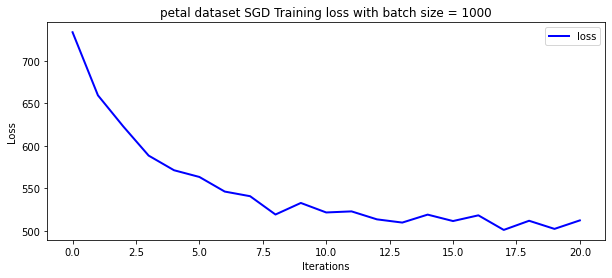

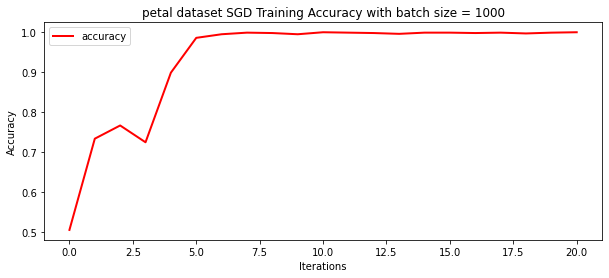

In [102]:
plt.figure(figsize=(10,4))
plt.plot(range(len(petal_losses)), petal_losses, lw=2, color='blue', label='loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('petal dataset SGD Training loss with batch size = {}'.format(BATCH_SIZE_PETALS))

plt.figure(figsize=(10,4))
plt.plot(range(len(petal_train_accuracies)), petal_train_accuracies, lw=2, color='red', label='accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('petal dataset SGD Training Accuracy with batch size = {}'.format(BATCH_SIZE_PETALS))

# PART C: Calculate the accuracy on the test set

In [103]:
print('Petals dataset test set accuracy: {}'.format(check_accuracy(petals_net, petals_test_dataloader)))
print('Petals dataset train set accuracy: {}'.format(check_accuracy(petals_net, petals_train_dataloader)))

Petals dataset test set accuracy: 0.996999979019165
Petals dataset train set accuracy: 0.9987143278121948


# PART D: Plot the decision boundary

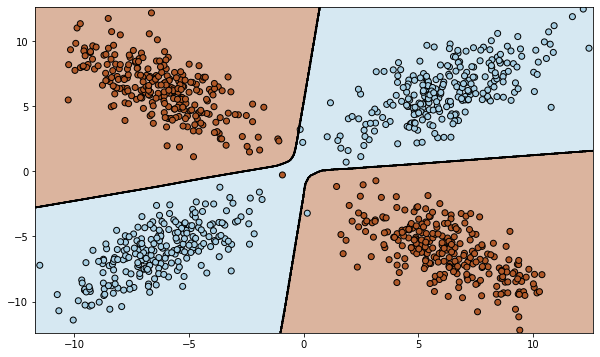

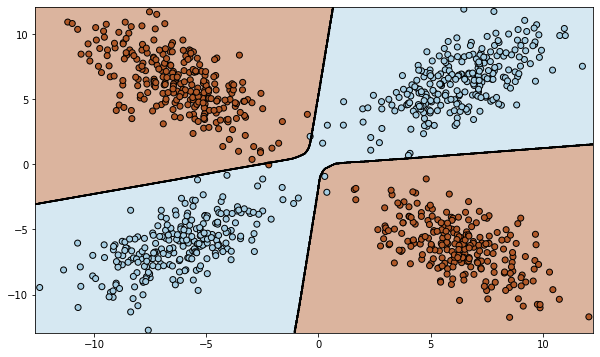

In [105]:
# Petal dataset batch 0 from test set
for batch_id, (data, target) in enumerate(petals_test_dataloader):
    plot_decision_boundary_nn(petals_net, data, target)